# Оценка поиска

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

Предположим у нас есть 5 поисковых запросов, по которым поисковая система выдала по 5 документов. Ассесоры поставили каждой паре запрос/документ оценку от 0 до 4. Зададим результаты в виде матрицы, где по строкам запросы, по столбцам - оценки. 

In [2]:
evaluation = [[4, 1, 3, 1, 0], 
              [0, 3, 3, 4, 0], 
              [0, 0, 0, 0, 2], 
              [4, 0, 0, 0, 3], 
              [1, 3, 0, 0, 0]
             ]

total_relevant_docs = [3, 3, 2, 2, 1]

In [3]:
q_idx = ['q%d' % (x + 1) for x in range(len(evaluation))]
pos_idx = ['pos%d' % (x + 1) for x in range(len(evaluation[0]))]
                                             
pd.DataFrame(data=evaluation, index=q_idx, columns=pos_idx)

,pos1,pos2,pos3,pos4,pos5
q1,4,1,3,1,0
q2,0,3,3,4,0
q3,0,0,0,0,2
q4,4,0,0,0,3
q5,1,3,0,0,0


Можно также построить матрицу бинарных оценок, где $\{2, 3, 4\}$ - релевантно, $\{0, 1\}$ - нерелевантно.

In [4]:
# бинарные оценки
evaluation_b = [[int(x in {2, 3, 4}) for x in lst] for lst in evaluation]
pd.DataFrame(data = evaluation_b, index=q_idx, columns=pos_idx)

,pos1,pos2,pos3,pos4,pos5
q1,1,0,1,0,0
q2,0,1,1,1,0
q3,0,0,0,0,1
q4,1,0,0,0,1
q5,0,1,0,0,0


### Метрики
<table width="100%">
<tr><td>Precision: </td><td>$$P = \frac{tp}{tp + fp}$$</td></tr>
<tr><td>Recall:</td> <td>$$R = \frac{tp}{tp + fn}$$</td></tr>

<tr><td>F-measure:</td> <td>$$F = \frac{(\beta^2 + 1) P R}{\beta^2P + R}$$</td></tr>

<tr><td>Mean averaged precision:</td> <td>$$\text{MAP} = \frac{1}{|Q|}\sum_{j=1}^{|Q|}\frac{1}{m_j}\sum_{k=1}^{m_j}P(R_{jk})$$</td></tr>

<tr><td>Mean reciprocal rank: </td><td>$$\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}$$</td></tr>

<tr><td>Discounted Cumulative Gain:</td> <td>$$\text{DCG}_k = \frac{1}{|Q|} \sum_{j=1}^{|Q|}\sum_{i=1}^{k}\frac{2^{\text{rel}_i}}{\log (i + 1)}$$</td></tr>
<tr><td>Yandex p-found:</td> <td>$$\text{pfound}=\frac{1}{|Q|} \sum_{j=1}^{|Q|}   \sum_{i=1}^{k} \text{plook}_i \text{prel}_i$$
<br/>
$$\text{plook}_i = \text{plook}_{i-1} (1 - \text{prel}_{i-1}) (1 -  \text{pbreak})$$</td></tr>
</table>

In [5]:
def safe_div(a, b):
    return 1.0 * a / b if b != 0 else 0.

def P(serp, total_rel):
    tp = sum(serp)
    fp = len(serp) - tp
    return safe_div(tp, tp + fp)
    
def R(serp, total_rel):
    tp = sum(serp)
    fn = total_rel - tp
    return safe_div(tp, tp + fn)

def P_k(k):
    def _P_k(serp, total_rel):
        tp = sum(serp[:k])
        fp = k - tp
        return safe_div(tp, tp + fp)
    _P_k.__name__ = str('P@%d' % k)
    return _P_k

def R_prec(serp, total_rel):
    tp = sum(serp[:total_rel])
    fp = total_rel - tp
    return safe_div(tp, tp + fp)

def MRR(serp, total_rel):
    for k, d in enumerate(serp, 1):
        if d == 1:
            return 1. / k
    return 0.

def MAP(serp, total_rel):
    acc = 0.
    for k, d in enumerate(serp, 1):
        prec = P_k(k)(serp, total_rel) * d
        acc += prec
    return acc / total_rel

for metric in [P, R, P_k(1), P_k(3), R_prec, MRR, MAP]:
    avg = 0.
    for serp, total_rel in zip(evaluation_b, total_relevant_docs):
        avg += metric(serp, total_rel)
    print ('{:<6} - {:3.3f}'.format(metric.__name__, avg / len(total_relevant_docs)))



P      - 0.360
R      - 0.833
P@1    - 0.400
P@3    - 0.400
R_prec - 0.367
MRR    - 0.640
MAP    - 0.499


In [6]:
def interpolated_P(serp, total_rel):
    tp = fp = 0
    lst_p = [] 
    lst_r = [] 
    for d in serp:
        if d == 1:
            tp += 1
            p = safe_div(tp, tp + fp)
            r = safe_div(tp, total_rel)
            lst_p.append(p)
            lst_r.append(r)
        else:
            fp += 1        
    # очень неоптимально         
    def at_value(x):        
        for i in range(len(lst_p)):
            if lst_r[i] >= x:
                return max(lst_p[i:])
        return None

    return at_value

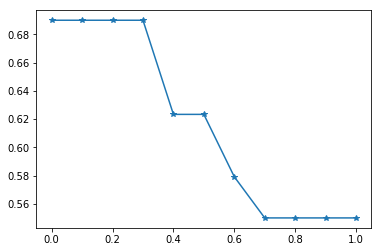

In [7]:
%matplotlib inline

values = []
for x in np.linspace(0., 1., 11):
    acc = []
    for serp, total_rel in zip(evaluation_b, total_relevant_docs):   
        int_p = interpolated_P(serp, total_rel)    
        v = int_p(x)
        if v is not None:
            acc.append(v)
    values.append(np.mean(acc))    

plt.plot(np.linspace(0., 1., 11), values, '*-')

In [8]:
def DCG(serp, total_rel):
    acc = 0.
    for k, d in enumerate(serp, 1):
        acc += (2**d - 1) / np.log(1. + k)
    return acc
    
def NDCG(serp, total_rel):
    ss = sorted(serp, key=lambda x: -x)
    return DCG(serp, total_rel) / DCG(ss, total_rel)


In [9]:
for metric in [DCG, NDCG]:
    avg = 0.
    for serp, total_rel in zip(evaluation, total_relevant_docs):
        avg += metric(serp, total_rel)
    print ('{:<6} - {:3.3f}'.format(metric.__name__, avg / len(total_relevant_docs)))

DCG    - 16.800
NDCG   - 0.719
